In [13]:
!pip install ortools

from ortools.linear_solver import pywraplp
import pandas as pd



# Original Model

In [14]:
import numpy as np
from scipy.optimize import linprog

# Define the Decision Variables
# GW: amount of groundwater to use [m3]
# SW: amount of surface water to use [m3]
# E: amount of non-renewable energy to produce [kWh]
# ER: amount of renewable energy to produce [kWh]

# Initialize the inequality (A_ub) and equality (A_eq) constraint matrices
A_ub = []
A_eq = []

# Initialize the right-hand sides of inequality and equality constraints (b_ub and b_eq)
b_ub = []
b_eq = []


# Define the Parameters
# for water supply
GWA = 2000  # Groundwater use allowance (Groundwater availability) [m3]
SWA = 1000  # Surface water use allowance (Surface water availability) [m3]

# for water demand
WD = 2700  # Water Demand (total for urban + agriculture) [m3]

# for energy supply
EA = 5000  # Energy production capacity from non-renewable sources (Energy Availability) [kWh]
ERA = 3000  # Energy production capacity from renewable sources (Energy Renewable Availability) [kWh]

# for energy demand
ED = 6500  # Energy Demand (total for urban + agriculture) [kWh]

# for costs
GWC = 1.5  # Cost for using groundwater [$/m3]
SWC = 1.2  # Cost for using surface water [$/m3]
EC = 0.2  # Cost for using non-renewable energy [$/kWh]
ERC = 0.25  # Cost for using renewable energy [$/kWh]

B = 12000  # Budget (maximum money available) [$]

# for Carbon emissions
GWE = 0.15  # Groundwater emissions [kg CO2/m3]
SWE = 0.05  # Surface water emissions [kg CO2/m3]
EE = 0.25  # Non-renewable energy emissions [kg CO2/kWh]
ERE = 0.02  # Renewable energy emissions [kg CO2/kWh]

GHG = 4500  # Emissions (maximum allowable CO2 emissions) [kg CO2]

# Step 5: Define the Constraints
# TWA: Total Water Availability = GWA + SWA
TWA = GWA + SWA

# TEA: Total Energy Availability = EA + ERA
TEA = EA + ERA

# Define the coefficients for the objective function (c)
c = [GWC, SWC, EC, ERC]

# Define constraints
# Constraints are represented as: Ax <= b

# Water availability constraint: GW + SW <= TWA [m3]
A_ub.append([1, 1, 0, 0])
b_ub.append(TWA)

# Energy availability constraint: E + ER <= TEA [kWh]
A_ub.append([0, 0, 1, 1])
b_ub.append(TEA)

# Water demand constraint: GW + SW = WD [m3]
A_eq.append([1, 1, 0, 0])
b_eq.append(WD)

# Energy demand constraint: E + ER = ED [kWh]
A_eq.append([0, 0, 1, 1])
b_eq.append(ED)

# Carbon emission allowance
A_ub.append([GWE, SWE, EE, ERE])
b_ub.append(GHG)

# Budget available
A_ub.append([GWC, SWC, EC, ERC])
b_ub.append(B)

# Groundwater capacity: GW <= GWA [m3]
A_ub.append([1, 0, 0, 0])
b_ub.append(GWA)

# Surface water capacity: SW = SWA [m3]
A_eq.append([0, 1, 0, 0])
b_eq.append(SWA)

# Non-renewable energy production capacity: E <= EA [kWh]
A_ub.append([0, 0, 1, 0])
b_ub.append(EA)

# Renewable energy production capacity: ER <= ERA [kWh]
A_ub.append([0, 0, 0, 1])
b_ub.append(ERA)

# Convert lists to NumPy arrays
A_ub = np.array(A_ub)
A_eq = np.array(A_eq)
b_ub = np.array(b_ub)
b_eq = np.array(b_eq)

# Solve the linear program
result = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, method='highs')


# Get the Results
# Check if a solution was found
if result.success:
    print("Optimal Solution Found!")
    print("Objective Function =", result.fun)
    print("Decision Variables:")
    print("GW:", result.x[0], "m3")
    print("SW:", result.x[1], "m3")
    print("E:", result.x[2], "kWh")
    print("ER:", result.x[3], "kWh")
    print("Optimized TWA =", TWA - result.x[0] - result.x[1], "m3, remaining water available (environmental flows)")
    print("Optimized TEA =", TEA - result.x[2] - result.x[3], "kWh, remaining energy available (can be renewable instead of non-renewable)")
    print("Optimized GHG =", GHG - (GWE * result.x[0] + SWE * result.x[1] + EE * result.x[2] + ERE * result.x[3]), "kg CO2, compared to the maximum allowable emissions of 4500 kg CO2 ")
    print("Optimized Budget =", B - (GWC * result.x[0] + SWC * result.x[1] + EC * result.x[2] + ERC * result.x[3]), "$, compared to the maximum budget of 12000 $")
else:
    print("No feasible solution found. Check your constraints and parameters.")

Optimal Solution Found!
Objective Function = 5125.0
Decision Variables:
GW: 1700.0 m3
SW: 1000.0 m3
E: 5000.0 kWh
ER: 1500.0 kWh
Optimized TWA = 300.0 m3, remaining water available (environmental flows)
Optimized TEA = 1500.0 kWh, remaining energy available (can be renewable instead of non-renewable)
Optimized GHG = 2915.0 kg CO2, compared to the maximum allowable emissions of 4500 kg CO2 
Optimized Budget = 6875.0 $, compared to the maximum budget of 12000 $


* Optmized GHG and budget in the original model dont match results, but since that does not affect results, its just a complementary calculation, we just fixed it in the replication

# OR-Tools Model


In [15]:
# Starting solver
solver = pywraplp.Solver.CreateSolver("GLOP")

# Parameters
GWA, SWA = 2000, 1000     # m3 - Groundwater use allowance (Groundwater availability), Surface water use allowance (Surface water availability)
WD = 2700                 # m3 - Water Demand (total for urban + agriculture)
EA, ERA = 5000, 3000      # kWh - Energy production capacity from non-renewable sources (Energy Availability), Energy production capacity from renewable sources (Energy Renewable Availability)
ED = 6500                 # kWh - Energy Demand (total for urban + agriculture)
B = 12000                 # USD - Budget (maximum money available) [$]
GHG = 4500                # kg CO2 - Emissions (maximum allowable CO2 emissions)


GWC, SWC = 1.5, 1.2       # USD/m3 - Cost for using groundwater, Cost for using surface water [$/m3]
EC, ERC = 0.2, 0.25       # USD/kWh - Cost for using non-renewable energy, Cost for using renewable energy [$/kWh]
GWE, SWE = 0.15, 0.05     # kg CO2/m3 - Groundwater emissions, Surface water emissions [kg CO2/m3]
EE, ERE = 0.25, 0.02      # kg CO2/kWh - Non-renewable energy emissions, Renewable energy emissions [kg CO2/kWh]

# Decision Variables
GW = solver.NumVar(0, GWA, "GW") # GW: amount of groundwater to use [m3]
SW = solver.NumVar(0, SWA, "SW") # SW: amount of surface water to use [m3]
E  = solver.NumVar(0, EA, "E") # E: amount of non-renewable energy to produce [kWh]
ER = solver.NumVar(0, ERA, "ER") # ER: amount of renewable energy to produce [kWh]

# Constraints
solver.Add(GW + SW <= GWA + SWA)   # TWA: Total Water Availability
solver.Add(E + ER <= EA + ERA)     # TEA: Total Energy Availability
solver.Add(GW + SW == WD)
solver.Add(E + ER == ED)
solver.Add(GWE*GW + SWE*SW + EE*E + ERE*ER <= GHG)
solver.Add(GWC*GW + SWC*SW + EC*E + ERC*ER <= B)

# Objective Function
solver.Minimize(GWC*GW + SWC*SW + EC*E + ERC*ER) # Minimize cost

# Find Solution
status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    # fetch solver results
    gw_val = GW.solution_value()
    sw_val = SW.solution_value()
    e_val  = E.solution_value()
    er_val = ER.solution_value()
    total_cost      = solver.Objective().Value()

    # 1) remaining water (environmental flows)
    total_water_used  = gw_val + sw_val
    remaining_water   = GWA + SWA - total_water_used

    # 2) remaining energy availability
    total_energy_used = e_val + er_val
    remaining_energy  = EA + ERA - total_energy_used

    # 3) actual GHG emissions
    total_ghg = (GWE * gw_val
               + SWE * sw_val
               + EE  * e_val
               + ERE * er_val)

    # output everything
    print("Optimal solution found:")
    print(f"  GW = {gw_val:.2f} m³")
    print(f"  SW = {sw_val:.2f} m³")
    print(f"   E = {e_val:.2f} kWh")
    print(f"  ER = {er_val:.2f} kWh")
    print(f"Total Cost = ${total_cost:.2f}")

    print(f"\nOptimized TWA = {remaining_water:.2f} m³ remaining (environmental flows)")
    print(f"Optimized TEA = {remaining_energy:.2f} kWh remaining")
    print(f"Optimized GHG = {total_ghg:.2f} kg CO₂ (allowable {GHG} kg)")
    print(f"Optimized Budget = ${total_cost:.2f} (budget cap ${B})")


Optimal solution found:
  GW = 1700.00 m³
  SW = 1000.00 m³
   E = 5000.00 kWh
  ER = 1500.00 kWh
Total Cost = $5125.00

Optimized TWA = 300.00 m³ remaining (environmental flows)
Optimized TEA = 1500.00 kWh remaining
Optimized GHG = 1585.00 kg CO₂ (allowable 4500 kg)
Optimized Budget = $5125.00 (budget cap $12000)


# OR-Tools Model Expansion

In [16]:
!pip install ortools
from ortools.linear_solver import pywraplp

In [25]:
# Create the solver using SCIP (supports integer programming)
solver = pywraplp.Solver.CreateSolver("SCIP")

months = 24

# Parameters
GWA_A = 1200      # m3 - Groundwater use allowance (Groundwater availability A)
GWA_B = 800       # m3 -  Groundwater use allowance (Groundwater availability B)
TREAT_CAP = 1000  # m3 -  Treated water use Cap
SWA = 1000        # m3 - Surface water use allowance (Surface water availability)

E1A = 400         # kWh - Energy production capacity from Coal, Peat and Manufactured Gases
E2A = 800         # kWh - Energy production capacity from Combustible Renewables
E3A = 620         # kWh - Energy production capacity from Geothermal
E4A = 2500        # kWh - Energy production capacity from Hydro
E5A = 500         # kWh - Energy production capacity from Natural Gas
E6A = 750         # kWh - Energy production capacity from Nuclear
E7A = 1500        # kWh - Energy production capacity from Oil and Petroleum Products
E8A = 530         # kWh - Energy production capacity from Solar
E9A = 800         # kWh - Energy production capacity from Wind

ED_base = 6500    # kWh - Energy Demand (total for urban + agriculture)
B = 12000         # USD - Budget (maximum money available) [$]
GHG = 4500        # kg CO2 - Emissions (maximum allowable CO2 emissions)

# Cost Parameters
GWC = 1.5         # USD/m3 - Cost for using groundwater

GWC_A = 1.8         # USD/m3 - Cost for using groundwater
GWC_B = 1.5         # USD/m3 - Cost for using groundwater
SWC = 1.2         # USD/m3 - Cost for using surface water [$/m3]
CTREAT = 0.7      # USD/m3 - Cost for using treated water

E1C = 0.1         # USD/kWh - Cost for using E1 energy
E2C = 0.075       # USD/kWh - Cost for using E2 energy
E3C = 0.075       # USD/kWh - Cost for using E3 energy
E4C = 0.055       # USD/kWh - Cost for using E4 energy
E5C = 0.07        # USD/kWh - Cost for using E5 energy
E6C = 0.09        # USD/kWh - Cost for using E6 energy
E7C = 0.175       # USD/kWh - Cost for using E7 energy
E8C = 0.045       # USD/kWh - Cost for using E8 energy
E9C = 0.04        # USD/kWh - Cost for using E9 energy

# Emission Parameters
GWE = 0.15         # kg CO2/m3 - Groundwater emissions

GWE_A = 0.12         # kg CO2/m3 - Groundwater emissions
GWE_B = 0.15         # kg CO2/m3 - Groundwater emissions
SWE = 0.05         # kg CO2/m3 - Surface water emissions [kg CO2/m3]
ETREAT = 0.07      # kg CO2/m3 - water treatment emissions [kg CO2/m3]

E1E = 0.935        # kg CO2/kWh - E1 energy emissions
E2E = 0.055        # kg CO2/kWh - E2 energy emissions
E3E = 0.055        # kg CO2/kWh - E3 energy emissions
E4E = 0.005        # kg CO2/kWh - E4 energy emissions
E5E = 0.5          # kg CO2/kWh - E5 energy emissions
E6E = 0.015        # kg CO2/kWh - E6 energy emissions
E7E = 0.8          # kg CO2/kWh - E7 energy emissions
E8E = 0.01         # kg CO2/kWh - E8 energy emissions
E9E = 0.005        # kg CO2/kWh - E9 energy emissions


# Seasonality
WD_urban = [1600 + (100 if t % 12 in [5, 6, 7] else 0) for t in range(months)]
WD_agri = [1100 + (200 if t % 12 in [5, 6, 7] else 0) for t in range(months)]
WD = [WD_urban[t] + WD_agri[t] for t in range(months)]
ED = [ED_base + (300 if t % 12 in [11, 0, 1] else 0) for t in range(months)]

# Variables
GW_A, GW_B, SW, E1, E2, E3, E4, E5, E6, E7, E8, E9, TREAT, Y_A, Y_B = [], [], [], [], [], [], [], [], [], [], [], [], [], [], []

# range limit for each variable
for t in range(months):
    GW_A.append(solver.NumVar(0, GWA_A, f"GW_A_{t}"))
    GW_B.append(solver.NumVar(0, GWA_B, f"GW_B_{t}"))
    SW.append(solver.NumVar(0, SWA, f"SW_{t}"))
    E1.append(solver.NumVar(0, E1A, f"E1_{t}"))
    E2.append(solver.NumVar(0, E2A, f"E2_{t}"))
    E3.append(solver.NumVar(0, E3A, f"E3_{t}"))
    E4.append(solver.NumVar(0, E4A, f"E4_{t}"))
    E5.append(solver.NumVar(0, E5A, f"E5_{t}"))
    E6.append(solver.NumVar(0, E6A, f"E6_{t}"))
    E7.append(solver.NumVar(0, E7A, f"E7_{t}"))
    E8.append(solver.NumVar(0, E8A, f"E8_{t}"))
    E9.append(solver.NumVar(0, E9A, f"E9_{t}"))
    TREAT.append(solver.NumVar(0, TREAT_CAP, f"TREAT_{t}"))
    Y_A.append(solver.IntVar(0, 1, f"Y_A_{t}"))
    Y_B.append(solver.IntVar(0, 1, f"Y_B_{t}"))

    # Routing logic
    solver.Add(GW_A[t] <= GWA_A * Y_A[t])
    solver.Add(GW_B[t] <= GWA_B * Y_B[t])
    solver.Add(Y_A[t] + Y_B[t] <= 1)  # only one active

    # Constraints
    solver.Add(GW_A[t] + GW_B[t] + SW[t] + TREAT[t] == WD[t]) # Sum of water sources should be equal to total water demand
    solver.Add(SW[t] + TREAT[t] >= WD_urban[t]) # Superficial + treated water should be equal or greater than urban demand
    solver.Add(GW_A[t] + GW_B[t] + SW[t] <= GWA_A + GWA_B + SWA) # Water use should be lower or equal availability

    solver.Add(E1[t] + E2[t] + E3[t] + E4[t] + E5[t] + E6[t] + E7[t] + E8[t] + E9[t] == ED[t]) # Sum of energy sources should be equal to total demand
    solver.Add(E1[t] + E2[t] + E3[t] + E4[t] + E5[t] + E6[t] + E7[t] + E8[t] + E9[t] <= E1A + E2A + E3A + E4A + E5A + E6A + E7A + E8A + E9A) # Energy use should be lower or equal availability

    solver.Add(GWE_A * GW_A[t] + GWE_B * GW_B[t] + ETREAT * TREAT[t] + SWE * SW[t] +
               E1E * E1[t] + E2E * E2[t] + E3E * E3[t] + E4E * E4[t] + E5E * E5[t] + E6E * E6[t] + E7E * E7[t] + E8E * E8[t] + E9E * E9[t]
               <= GHG) # CO² Emissions limit
    solver.Add(
              GWC_A * GW_A[t] + GWC_B * GW_B[t] + SWC * SW[t] + CTREAT * TREAT[t] +
              E1C * E1[t] + E2C * E2[t] + E3C * E3[t] + E4C * E4[t] + E5C * E5[t] + E6C * E6[t] + E7C * E7[t] + E8C * E8[t] + E9C * E9[t]
              <= B ) # Budget limit

# Objective: minimize total cost
solver.Minimize(solver.Sum([
    GWC_A * GW_A[t] + GWC_B * GW_B[t] + SWC * SW[t] + CTREAT * TREAT[t] +
    E1C * E1[t] + E2C * E2[t] + E3C * E3[t] + E4C * E4[t] + E5C * E5[t] + E6C * E6[t] + E7C * E7[t] + E8C * E8[t] + E9C * E9[t]
    for t in range(months)
]))

# Solve
status = solver.Solve()

# Results
if status == pywraplp.Solver.OPTIMAL:
    results = []
    for t in range(months):
        results.append({
            'Month': t + 1,
            'GW_A': GW_A[t].solution_value(),
            'GW_B': GW_B[t].solution_value(),
            'Y_A_Used': int(Y_A[t].solution_value()),
            'Y_B_Used': int(Y_B[t].solution_value()),
            'SW': SW[t].solution_value(),
            'TREAT': TREAT[t].solution_value(),
            'E1': E1[t].solution_value(),
            'E2': E2[t].solution_value(),
            'E3': E3[t].solution_value(),
            'E4': E4[t].solution_value(),
            'E5': E5[t].solution_value(),
            'E6': E6[t].solution_value(),
            'E7': E7[t].solution_value(),
            'E8': E8[t].solution_value(),
            'E9': E9[t].solution_value(),
            'WD_Urban': WD_urban[t],
            'WD_Agri': WD_agri[t],
            'Total_WD': WD[t],
            'ED': ED[t],
        })

    df = pd.DataFrame(results)
    from IPython.display import display
    display(df)

else:
    print("No optimal solution found.")

,Month,GW_A,GW_B,Y_A_Used,Y_B_Used,SW,TREAT,E1,E2,E3,E4,E5,E6,E7,E8,E9,WD_Urban,WD_Agri,Total_WD,ED
0,1,0.0,700.0,0,1,1000.0,1000.0,300.0,800.0,620.0,2500.0,500.0,750.0,0.0,530.0,800.0,1600,1100,2700,6800
1,2,0.0,700.0,0,1,1000.0,1000.0,300.0,800.0,620.0,2500.0,500.0,750.0,0.0,530.0,800.0,1600,1100,2700,6800
2,3,0.0,700.0,0,1,1000.0,1000.0,0.0,800.0,620.0,2500.0,500.0,750.0,0.0,530.0,800.0,1600,1100,2700,6500
3,4,0.0,700.0,0,1,1000.0,1000.0,0.0,800.0,620.0,2500.0,500.0,750.0,0.0,530.0,800.0,1600,1100,2700,6500
4,5,0.0,700.0,0,1,1000.0,1000.0,0.0,800.0,620.0,2500.0,500.0,750.0,0.0,530.0,800.0,1600,1100,2700,6500
5,6,1000.0,0.0,1,0,1000.0,1000.0,0.0,800.0,620.0,2500.0,500.0,750.0,0.0,530.0,800.0,1700,1300,3000,6500
6,7,1000.0,0.0,1,0,1000.0,1000.0,0.0,800.0,620.0,2500.0,500.0,750.0,0.0,530.0,800.0,1700,1300,3000,6500
7,8,1000.0,0.0,1,0,1000.0,1000.0,0.0,800.0,620.0,2500.0,500.0,750.0,0.0,530.0,800.0,1700,1300,3000,6500
8,9,0.0,700.0,0,1,1000.0,1000.0,0.0,800.0,620.0,2500.0,500.0,750.0,0.0,530.0,800.0,1600,1100,2700,6500
9,10,0.0,700.0,0,1,1000.0,1000.0,0.0,800.0,620.0,2500.0,500.0,750.0,0.0,530.0,800.0,1600,1100,2700,6500


# Quick Visualization of expantion results


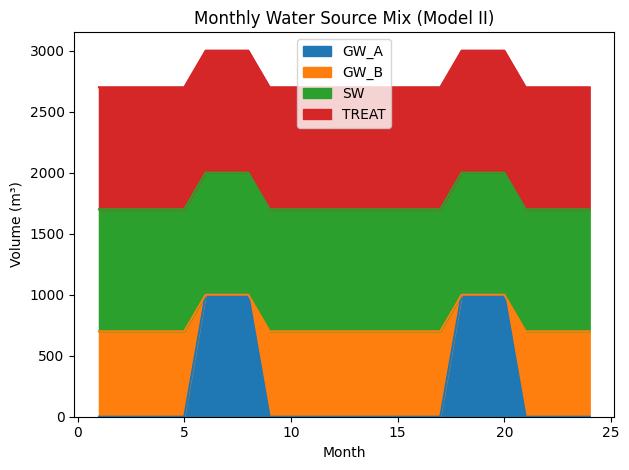

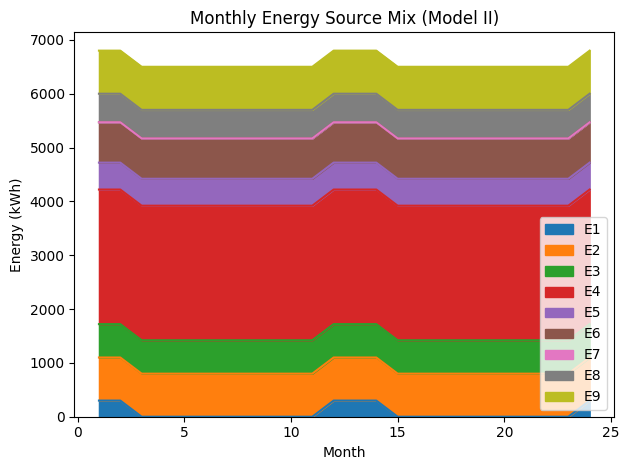

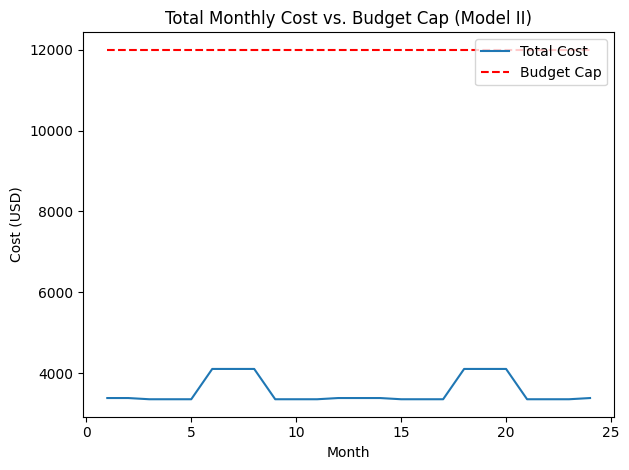

In [26]:
import matplotlib.pyplot as plt

# Ensure you have run Model II code and df exists with 'Month' and your variables.

# 1. Stacked area chart of water sources
df_plot = df.set_index('Month')
fig, ax = plt.subplots()
df_plot[['GW_A', 'GW_B', 'SW', 'TREAT']].plot.area(ax=ax)
ax.set_title('Monthly Water Source Mix (Model II)')
ax.set_xlabel('Month')
ax.set_ylabel('Volume (m³)')
plt.tight_layout()
plt.show()

# 2. Stacked area chart of energy sources
fig, ax = plt.subplots()
df_plot[['E1','E2','E3','E4','E5','E6','E7','E8','E9']].plot.area(ax=ax)
ax.set_title('Monthly Energy Source Mix (Model II)')
ax.set_xlabel('Month')
ax.set_ylabel('Energy (kWh)')
plt.tight_layout()
plt.show()

# 3. Line plot of total cost vs. budget cap
# Compute total cost per month
cost_series = (
    GWC_A * df['GW_A'] + GWC_B * df['GW_B'] +
    SWC   * df['SW']   + CTREAT * df['TREAT'] +
    E1C   * df['E1']   + E2C    * df['E2'] +
    E3C   * df['E3']   + E4C    * df['E4'] +
    E5C   * df['E5']   + E6C    * df['E6'] +
    E7C   * df['E7']   + E8C    * df['E8'] +
    E9C   * df['E9']
)
fig, ax = plt.subplots()
ax.plot(df['Month'], cost_series, label='Total Cost')
ax.hlines(B, xmin=df['Month'].min(), xmax=df['Month'].max(),
          linestyles='--', color='red', label='Budget Cap')
ax.set_title('Total Monthly Cost vs. Budget Cap (Model II)')
ax.set_xlabel('Month')
ax.set_ylabel('Cost (USD)')
ax.legend()
plt.tight_layout()
plt.show()


# Comparison of baseline with Model expansion
Since original model only provides a snapshot, comparison is highly difficult

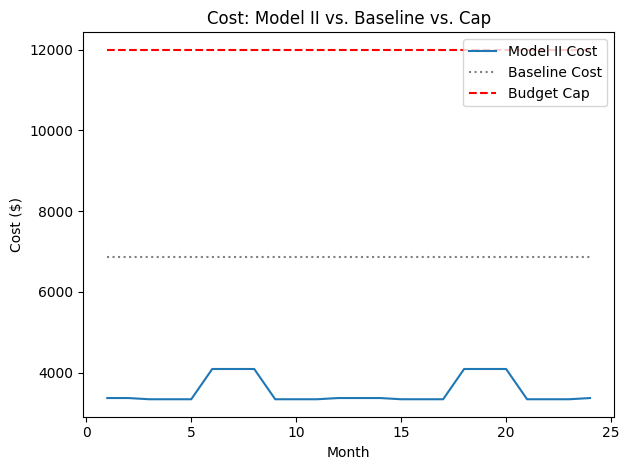

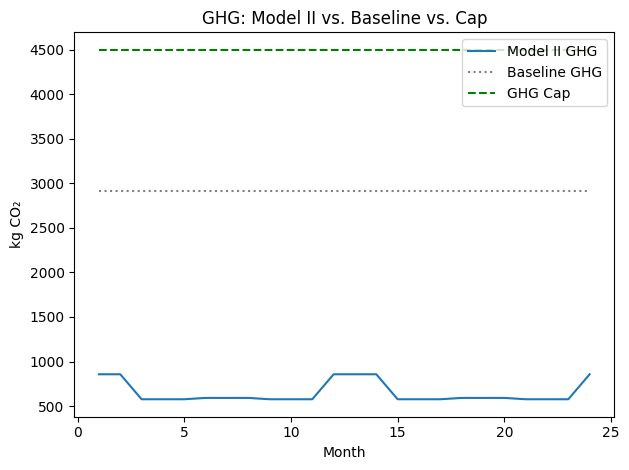

In [19]:
baseline_cost = 6875
baseline_ghg  = 2915
baseline_twa  = 300    # m³
baseline_tea  = 1500   # kWh

import matplotlib.pyplot as plt

# assume df_plot = df.set_index('Month')

# Cost vs. budget + baseline
fig, ax = plt.subplots()
df_plot_cost = (
    GWC_A * df_plot['GW_A'] + GWC_B * df_plot['GW_B'] +
    SWC   * df_plot['SW']   + CTREAT * df_plot['TREAT'] +
    E1C   * df_plot['E1']   + E2C    * df_plot['E2'] +
    E3C   * df_plot['E3']   + E4C    * df_plot['E4'] +
    E5C   * df_plot['E5']   + E6C    * df_plot['E6'] +
    E7C   * df_plot['E7']   + E8C    * df_plot['E8'] +
    E9C   * df_plot['E9']
)
ax.plot(df_plot.index, df_plot_cost, label='Model II Cost')
ax.hlines(baseline_cost, df_plot.index.min(), df_plot.index.max(),
          linestyles=':', color='gray', label='Baseline Cost')
ax.hlines(B, df_plot.index.min(), df_plot.index.max(),
          linestyles='--', color='red', label='Budget Cap')
ax.set_title('Cost: Model II vs. Baseline vs. Cap')
ax.set_xlabel('Month')
ax.set_ylabel('Cost ($)')
ax.legend()
plt.tight_layout()
plt.show()

# GHG vs. cap + baseline
fig, ax = plt.subplots()
ghg_series = (
    GWE_A * df_plot['GW_A'] + GWE_B * df_plot['GW_B'] +
    SWE   * df_plot['SW']   + ETREAT * df_plot['TREAT'] +
    E1E   * df_plot['E1']   + E2E    * df_plot['E2'] +
    E3E   * df_plot['E3']   + E4E    * df_plot['E4'] +
    E5E   * df_plot['E5']   + E6E    * df_plot['E6'] +
    E7E   * df_plot['E7']   + E8E    * df_plot['E8'] +
    E9E   * df_plot['E9']
)
ax.plot(df_plot.index, ghg_series, label='Model II GHG')
ax.hlines(baseline_ghg, df_plot.index.min(), df_plot.index.max(),
          linestyles=':', color='gray', label='Baseline GHG')
ax.hlines(GHG, df_plot.index.min(), df_plot.index.max(),
          linestyles='--', color='green', label='GHG Cap')
ax.set_title('GHG: Model II vs. Baseline vs. Cap')
ax.set_xlabel('Month')
ax.set_ylabel('kg CO₂')
ax.legend()
plt.tight_layout()
plt.show()


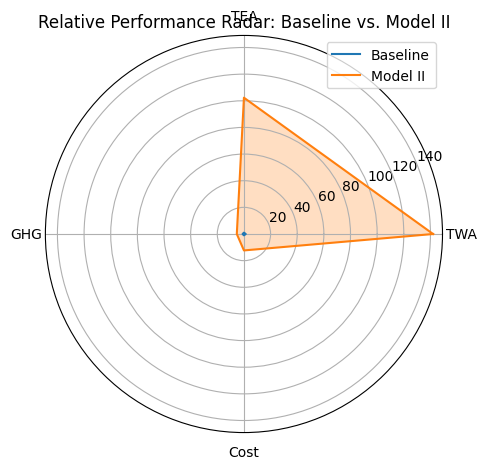

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare DataFrame
df_plot = df.set_index('Month')

# Recompute cost_series and ghg_series for Model II
cost_series = (
    GWC_A * df_plot['GW_A'] + GWC_B * df_plot['GW_B'] +
    SWC   * df_plot['SW']   + CTREAT * df_plot['TREAT'] +
    E1C   * df_plot['E1']   + E2C    * df_plot['E2'] +
    E3C   * df_plot['E3']   + E4C    * df_plot['E4'] +
    E5C   * df_plot['E5']   + E6C    * df_plot['E6'] +
    E7C   * df_plot['E7']   + E8C    * df_plot['E8'] +
    E9C   * df_plot['E9']
)
ghg_series = (
    GWE_A * df_plot['GW_A'] + GWE_B * df_plot['GW_B'] +
    SWE   * df_plot['SW']   + ETREAT * df_plot['TREAT'] +
    E1E   * df_plot['E1']   + E2E    * df_plot['E2'] +
    E3E   * df_plot['E3']   + E4E    * df_plot['E4'] +
    E5E   * df_plot['E5']   + E6E    * df_plot['E6'] +
    E7E   * df_plot['E7']   + E8E    * df_plot['E8'] +
    E9E   * df_plot['E9']
)

# Baseline snapshot KPIs
baseline = {
    'TWA': 300,
    'TEA': 1500,
    'GHG': 2915,
    'Cost': 6875
}

# Model II aggregate KPIs
extended = {
    'TWA': df_plot[['GW_A','GW_B','SW']].sum().sum(),
    'TEA': df_plot[['E1','E2','E3','E4','E5','E6','E7','E8','E9']].sum().sum(),
    'GHG': ghg_series.sum(),
    'Cost': cost_series.sum()
}

# Normalize relative to baseline (Baseline = 1.0)
categories = list(baseline.keys())
baseline_vals = [1.0] * len(categories)
extended_vals = [extended[k] / baseline[k] for k in categories]

# Radar plot setup
N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]
baseline_plot = baseline_vals + baseline_vals[:1]
extended_plot = extended_vals + extended_vals[:1]

fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
ax.plot(angles, baseline_plot, label='Baseline')
ax.fill(angles, baseline_plot, alpha=0.25)
ax.plot(angles, extended_plot, label='Model II')
ax.fill(angles, extended_plot, alpha=0.25)
ax.set_thetagrids(np.degrees(angles[:-1]), categories)
ax.set_title('Relative Performance Radar: Baseline vs. Model II')
ax.legend(loc='upper right')
ax.grid(True)

plt.tight_layout()
plt.show()


# Model Testing with Real or Synthetic Data

In [21]:

# Mount Google Drive to access project data
from google.colab import drive
drive.mount('/content/drive')

# Set path to data folder in Google Drive
data_dir = "/content/drive/MyDrive/Operations_Project_Article2"

# Define path to files
water_supply = f"{data_dir}/water_supply_monthly_2020_2025.xlsx"
water_demand = f"{data_dir}/water_demand_monthly_2020_2025.xlsx"
energy_supply_demand = f"{data_dir}/Monthly_energy.xlsx"
emissions_cost = f"{data_dir}/energy_timeseries.xlsx"

# Load data
df_watersupply = pd.read_excel(water_supply, sheet_name="Water_Split")
df_waterdemand = pd.read_excel(water_demand, sheet_name="Water_Demand")
df_en_supplydemand = pd.read_excel(energy_supply_demand, sheet_name="Sheet2")
df_emissionscost = pd.read_excel(emissions_cost, sheet_name="Energy_Data")

# run inspection code:
from IPython.display import display

# Dictionary mapping descriptive names to loaded DataFrames
datasets = {
    'Water Supply': df_watersupply,
    'Water Demand': df_waterdemand,
    'Cost & Emissions': df_emissionscost,
    'Energy Availability & Use': df_en_supplydemand
}

# Parse & index each DataFrame on its date column
df_waterdemand["Date"]    = pd.to_datetime(df_waterdemand["Date"])
df_waterdemand            = df_waterdemand.set_index("Date")

df_watersupply["Date"]    = pd.to_datetime(df_watersupply["Date"])
df_watersupply            = df_watersupply.set_index("Date")

df_en_supplydemand['Date'] = pd.to_datetime(df_en_supplydemand['Date'])
df_en_supplydemand.set_index('Date', inplace=True)

df_emissionscost["Month"] = pd.to_datetime(df_emissionscost["Month"])
df_emissionscost = df_emissionscost.set_index("Month")

# Define your master index from the water-demand file
master_dates = df_waterdemand.index
months = len(master_dates)


# Reindex all to that same monthly index, forward-filling any gaps
df_waterdemand = df_waterdemand.reindex(master_dates).fillna(method="ffill")
df_watersupply = df_watersupply.reindex(master_dates).fillna(method="ffill")
df_emissionscost = df_emissionscost.reindex(master_dates).fillna(method="ffill")

# Align to your model timeline (from df_waterdemand)
dates = df_waterdemand.index  # DatetimeIndex: 2020-01-01 … 2024-12-01
df_can = df_en_supplydemand.reindex(dates)

# List of your energy‐code columns
energy_codes = ['E1A','E2A','E3A','E4A','E5A','E6A','E7A','E8A','E9A']

# Build dict of capacity time‐series & a separate list for demand (ED)
cap_energy = {
    code: df_can[code].fillna(0).tolist()
    for code in energy_codes
}
ED = df_can['ED'].fillna(0).tolist()

# Water supply capacities (10^9 m³)
GWA_A = df_watersupply["GWA_A"].tolist()
GWA_B = df_watersupply["GWA_B"].tolist()
SWA   = df_watersupply["SWA"].tolist()
TREAT_CAP = 10  # if still constant

# Water demand series (10^9 m³)
WD_urban = df_waterdemand["WD_urban"].tolist()
WD_agri  = df_waterdemand["WD_agri"].tolist()
WD       = df_waterdemand["Total_Demand (10^9 m3)"].tolist()

# Energy availability & demand (GWh)
E1_A = cap_energy["E1A"]
E2_A = cap_energy["E2A"]
E3_A = cap_energy["E3A"]
E4_A = cap_energy["E4A"]
E5_A = cap_energy["E5A"]
E6_A = cap_energy["E6A"]
E7_A = cap_energy["E7A"]
E8_A = cap_energy["E8A"]
E9_A = cap_energy["E9A"]
ED = df_can["ED"].fillna(0).tolist()

# Cost & Emissions (per source)
GWC_A  = df_emissionscost["GWC_A"].tolist();  GWE_A  = df_emissionscost["GWE_A"].tolist()
GWC_B  = df_emissionscost["GWC_B"].tolist();  GWE_B  = df_emissionscost["GWE_B"].tolist()
SWC    = df_emissionscost["SWC"].tolist();    SWE    = df_emissionscost["SWE"].tolist()
CTREAT = df_emissionscost["CTREAT"].tolist(); ETREAT = df_emissionscost["ETREAT"].tolist()

E1C = df_emissionscost["E1C"].tolist();  E1E = df_emissionscost["E1E"].tolist()
E2C = df_emissionscost["E2C"].tolist();  E2E = df_emissionscost["E2E"].tolist()
E3C = df_emissionscost["E3C"].tolist();  E3E = df_emissionscost["E3E"].tolist()
E4C = df_emissionscost["E4C"].tolist();  E4E = df_emissionscost["E4E"].tolist()
E5C = df_emissionscost["E5C"].tolist();  E5E = df_emissionscost["E5E"].tolist()
E6C = df_emissionscost["E6C"].tolist();  E6E = df_emissionscost["E6E"].tolist()
E7C = df_emissionscost["E7C"].tolist();  E7E = df_emissionscost["E7E"].tolist()
E8C = df_emissionscost["E8C"].tolist();  E8E = df_emissionscost["E8E"].tolist()
E9C = df_emissionscost["E9C"].tolist();  E9E = df_emissionscost["E9E"].tolist()


# Global budgets / caps
B   = 4500    # budget monthly cap
GHG = 6500    # Emissions monthly cap

# Create the solver using SCIP (supports integer programming)
solver = pywraplp.Solver.CreateSolver("SCIP")

# Variables
GW_A, GW_B, SW, E1, E2, E3, E4, E5, E6, E7, E8, E9, TREAT, Y_A, Y_B = [], [], [], [], [], [], [], [], [], [], [], [], [], [], []

# range limit for each variable
for t in range(months):
    GW_A.append(solver.NumVar(0, GWA_A[t], f"GW_A_{t}"))
    GW_B.append(solver.NumVar(0, GWA_B[t], f"GW_B_{t}"))
    SW.append(solver.NumVar(0, SWA[t], f"SW_{t}"))
    E1.append(solver.NumVar(0, E1_A[t], f"E1_{t}"))
    E2.append(solver.NumVar(0, E2_A[t], f"E2_{t}"))
    E3.append(solver.NumVar(0, E3_A[t], f"E3_{t}"))
    E4.append(solver.NumVar(0, E4_A[t], f"E4_{t}"))
    E5.append(solver.NumVar(0, E5_A[t], f"E5_{t}"))
    E6.append(solver.NumVar(0, E6_A[t], f"E6_{t}"))
    E7.append(solver.NumVar(0, E7_A[t], f"E7_{t}"))
    E8.append(solver.NumVar(0, E8_A[t], f"E8_{t}"))
    E9.append(solver.NumVar(0, E9_A[t], f"E9_{t}"))
    TREAT.append(solver.NumVar(0, TREAT_CAP, f"TREAT_{t}"))
    Y_A.append(solver.IntVar(0, 1, f"Y_A_{t}"))
    Y_B.append(solver.IntVar(0, 1, f"Y_B_{t}"))

    # Routing logic
    solver.Add(GW_A[t] <= GWA_A[t] * Y_A[t])
    solver.Add(GW_B[t] <= GWA_B[t] * Y_B[t])
    solver.Add(Y_A[t] + Y_B[t] <= 1)  # only one active

    # Constraints
    solver.Add(GW_A[t] + GW_B[t] + SW[t] + TREAT[t] == WD[t]) # Sum of water sources should be equal to total water demand
    solver.Add(GW_A[t] + GW_B[t] + SW[t] + TREAT[t] <= GWA_A[t] + GWA_B[t] + SWA[t] + TREAT_CAP) # Water use should be lower or equal availability

    solver.Add(E1[t] + E2[t] + E3[t] + E4[t] + E5[t] + E6[t] + E7[t] + E8[t] + E9[t] == ED[t]) # Sum of energy sources should be equal to total demand
    solver.Add(E1[t] + E2[t] + E3[t] + E4[t] + E5[t] + E6[t] + E7[t] + E8[t] + E9[t] <= E1_A[t] + E2_A[t] + E3_A[t] + E4_A[t] + E5_A[t] + E6_A[t] + E7_A[t] + E8_A[t] + E9_A[t]) # Energy use should be lower or equal availability

    solver.Add(GWE_A[t] * GW_A[t] + GWE_B[t] * GW_B[t] + ETREAT[t] * TREAT[t] + SWE[t] * SW[t] +
               E1E[t] * E1[t] + E2E[t] * E2[t] + E3E[t] * E3[t] + E4E[t] * E4[t] + E5E[t] * E5[t] + E6E[t] * E6[t] + E7E[t] * E7[t] + E8E[t] * E8[t] + E9E[t] * E9[t]
               <= GHG) # CO² Emissions limit
    solver.Add(
              GWC_A[t] * GW_A[t] + GWC_B[t] * GW_B[t] + SWC[t] * SW[t] + CTREAT[t] * TREAT[t] +
              E1C[t] * E1[t] + E2C[t] * E2[t] + E3C[t] * E3[t] + E4C[t] * E4[t] + E5C[t] * E5[t] + E6C[t] * E6[t] + E7C[t] * E7[t] + E8C[t] * E8[t] + E9C[t] * E9[t]
              <= B ) # Budget limit

# Objective: minimize total cost
solver.Minimize(solver.Sum([
    GWC_A[t] * GW_A[t] + GWC_B[t] * GW_B[t] + SWC[t] * SW[t] + CTREAT[t] * TREAT[t] +
    E1C[t] * E1[t] + E2C[t] * E2[t] + E3C[t] * E3[t] + E4C[t] * E4[t] + E5C[t] * E5[t] + E6C[t] * E6[t] + E7C[t] * E7[t] + E8C[t] * E8[t] + E9C[t] * E9[t]
    for t in range(months)
]))

# Solve
status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    results = []
    # enumerate over your actual timestamps
    for t, date in enumerate(master_dates):
        results.append({
            'Date':     date,                       # ← actual Timestamp here
            'GW_A':     GW_A[t].solution_value(),
            'GW_B':     GW_B[t].solution_value(),
            'Y_A_Used': int(Y_A[t].solution_value()),
            'Y_B_Used': int(Y_B[t].solution_value()),
            'SW':       SW[t].solution_value(),
            'TREAT':    TREAT[t].solution_value(),
            'E1':       E1[t].solution_value(),
            'E2':       E2[t].solution_value(),
            'E3':       E3[t].solution_value(),
            'E4':       E4[t].solution_value(),
            'E5':       E5[t].solution_value(),
            'E6':       E6[t].solution_value(),
            'E7':       E7[t].solution_value(),
            'E8':       E8[t].solution_value(),
            'E9':       E9[t].solution_value(),
            'WD_Urban': WD_urban[t],
            'WD_Agri':  WD_agri[t],
            'Total_WD': WD[t],
            'ED':       ED[t],
        })

    # build DataFrame and set the Date column as index
    df = pd.DataFrame(results)
    df.set_index('Date', inplace=True)
    from IPython.display import display
    display(df)

else:
    print("No optimal solution found.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-21-1233234487.py:50: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_waterdemand = df_waterdemand.reindex(master_dates).fillna(method="ffill")
/tmp/ipython-input-21-1233234487.py:51: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_watersupply = df_watersupply.reindex(master_dates).fillna(method="ffill")
/tmp/ipython-input-21-1233234487.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_emissionscost = df_emissionscost.reindex(master_dates).fillna(method="ffill")


,GW_A,GW_B,Y_A_Used,Y_B_Used,SW,TREAT,E1,E2,E3,E4,E5,E6,E7,E8,E9,WD_Urban,WD_Agri,Total_WD,ED
Date,,,,,,,,,,,,,,,,,,,
2020-01-01,0.0,16.672794,0,1,6.747636,10.0,3476.738300,929.9391,-0.0,38811.2358,0.0000,8896.854300,0.0000,109.0916,2799.9374,21.803326,11.617104,33.420429,55023.7965
2020-02-01,0.0,0.000000,1,0,128.585436,10.0,0.000000,851.7149,-0.0,36190.6095,6200.8717,4213.271400,0.0000,190.7240,3456.6076,91.844442,46.740995,138.585436,51103.7991
2020-03-01,0.0,0.000000,1,0,372.880339,10.0,0.000000,0.0000,-0.0,35319.4748,6078.2537,5112.975300,0.0000,337.4059,3303.0071,274.182641,108.697698,382.880339,50151.1168
2020-04-01,0.0,0.000000,1,0,15.017326,10.0,0.000000,685.2434,-0.0,29082.6004,1207.5436,7537.514300,0.0000,382.6227,2977.5745,17.447686,7.569639,25.017326,41873.0989
2020-05-01,0.0,0.000000,1,0,251.839912,10.0,2327.889300,603.4510,-0.0,28466.2339,4393.3980,111.741100,0.0000,452.9823,2734.9505,162.088069,99.751843,261.839912,39090.6461
2020-06-01,0.0,0.000000,1,0,282.767963,10.0,2514.826200,651.9101,-0.0,28260.0627,4746.2018,563.032200,306.5402,524.7346,2250.5529,188.630919,104.137044,292.767963,39817.8607
2020-07-01,0.0,0.000000,1,0,48.887089,10.0,3032.266100,0.0000,-0.0,31316.3418,5722.7602,1169.098700,0.0000,540.3594,1834.0032,40.798823,18.088266,58.887089,43614.8294
2020-08-01,0.0,0.000000,0,1,11.295610,10.0,0.000000,818.7694,-0.0,29664.0882,430.1381,8196.990600,0.0000,465.3514,2283.8168,14.247625,7.047986,21.295610,41859.1545
2020-09-01,0.0,0.000000,1,0,137.712404,10.0,0.000000,741.9555,-0.0,26207.9173,5401.7738,3173.001900,0.0000,423.1567,2832.8283,104.333155,43.379249,147.712404,38780.6335


In [22]:
# Build the second “metrics” table
metrics = []
for t, date in enumerate(master_dates):
    # 1) Water: environmental abstraction vs. capacity
    water_used_env = (
        GW_A[t].solution_value() +
        GW_B[t].solution_value() +
        SW[t].solution_value()
    )
    water_cap_env = GWA_A[t] + GWA_B[t] + SWA[t]
    remaining_water = water_cap_env - water_used_env

    # 2) Energy: total use vs. capacity
    energy_used = sum(var[t].solution_value()
                      for var in [E1, E2, E3, E4, E5, E6, E7, E8, E9])
    energy_cap = sum(cap_energy[code][t] for code in energy_codes)
    remaining_energy = energy_cap - energy_used

    # 3) GHG emissions
    ghg_used = (
        GWE_A[t] * GW_A[t].solution_value() +
        GWE_B[t] * GW_B[t].solution_value() +
        SWE[t]   * SW[t].solution_value()   +
        ETREAT[t]* TREAT[t].solution_value() +
        sum(coeff[t] * var[t].solution_value()
            for coeff, var in zip(
                [E1E, E2E, E3E, E4E, E5E, E6E, E7E, E8E, E9E],
                [E1, E2, E3, E4, E5, E6, E7, E8, E9]
            )
        )
    )

    # 4) Budget (costs)
    budget_used = (
        GWC_A[t] * GW_A[t].solution_value() +
        GWC_B[t] * GW_B[t].solution_value() +
        SWC[t]   * SW[t].solution_value()   +
        CTREAT[t]* TREAT[t].solution_value() +
        sum(cost[t] * var[t].solution_value()
            for cost, var in zip(
                [E1C, E2C, E3C, E4C, E5C, E6C, E7C, E8C, E9C],
                [E1,  E2,  E3,  E4,  E5,  E6,  E7,  E8,  E9]
            )
        )
    )

    metrics.append({
        'Date':                  date,
        'Optimized TWA (m³)':    water_used_env,
        'Rem. water avail. (m³)': remaining_water,
        'Optimized TEA (kWh)':   energy_used,
        'Rem. energy avail. (kWh)': remaining_energy,
        'Optimized GHG (kgCO₂)':  ghg_used,
        'Max allowable GHG':     GHG,
        'Optimized Budget ($)':   budget_used,
        'Max Budget ($)':         B,
    })

df_metrics = pd.DataFrame(metrics).set_index('Date')

from IPython.display import display
display(df_metrics)


,Optimized TWA (m³),Rem. water avail. (m³),Optimized TEA (kWh),Rem. energy avail. (kWh),Optimized GHG (kgCO₂),Max allowable GHG,Optimized Budget ($),Max Budget ($)
Date,,,,,,,,
2020-01-01,23.420429,42.246211,55023.7965,7318.2744,3298.164620,6500,2680.084253,4500
2020-02-01,128.585436,169.195171,51103.7991,6910.2137,3583.333991,6500,3773.048463,4500
2020-03-01,372.880339,369.364981,50151.1168,7272.5595,2595.206063,6500,3128.819984,4500
2020-04-01,15.017326,34.477934,41873.0989,6746.9678,1036.912700,6500,2123.458265,4500
2020-05-01,251.839912,229.236222,39090.6461,7651.8503,5155.211404,6500,2433.579070,4500
2020-06-01,282.767963,190.419215,39817.8607,7390.3654,5072.358532,6500,3463.211901,4500
2020-07-01,48.887089,61.892119,43614.8294,9042.3720,5994.993141,6500,2385.715685,4500
2020-08-01,11.295610,29.547632,41859.1545,9074.3829,497.850100,6500,2220.504164,4500
2020-09-01,137.712404,278.675015,38780.6335,6739.4657,3084.229876,6500,2593.898755,4500


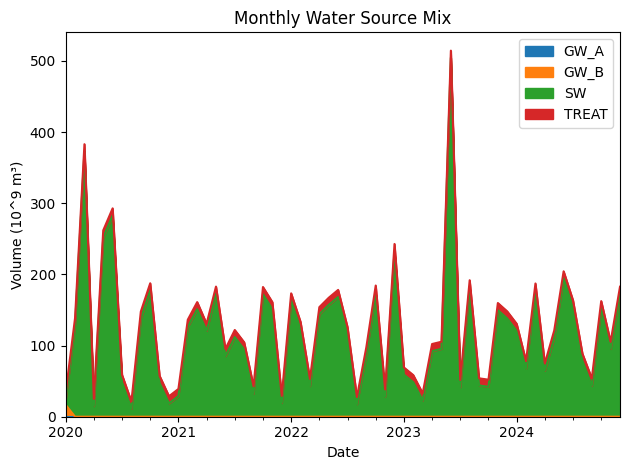

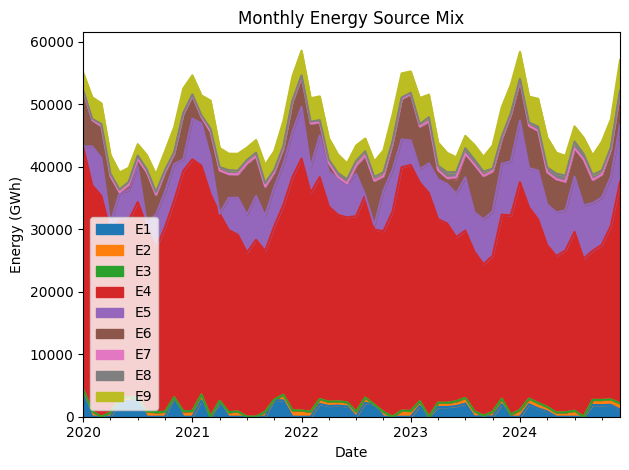

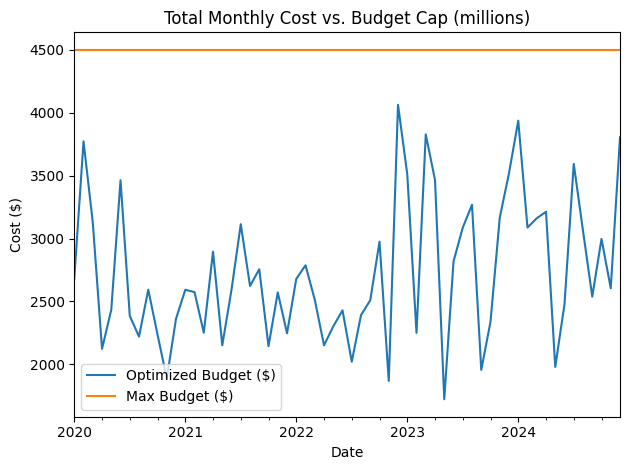

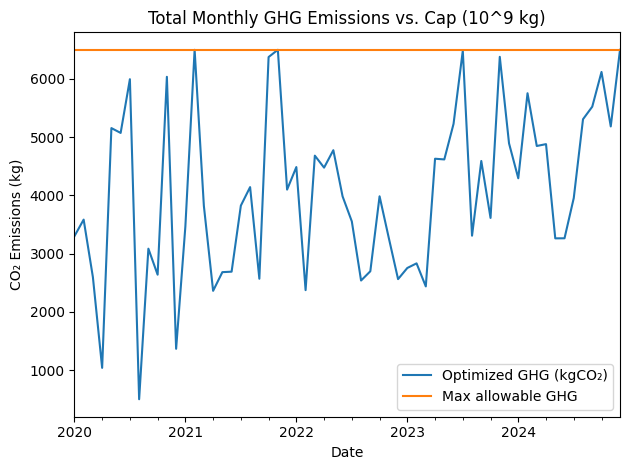

In [23]:
import matplotlib.pyplot as plt

# 1. Stacked area chart of water sources
fig, ax = plt.subplots()
df[['GW_A','GW_B','SW','TREAT']].plot.area(ax=ax)
ax.set_title('Monthly Water Source Mix')
ax.set_xlabel('Date')
ax.set_ylabel('Volume (10^9 m³)')
plt.tight_layout()
plt.show()

# 2. Stacked area chart of energy sources
fig, ax = plt.subplots()
df[['E1','E2','E3','E4','E5','E6','E7','E8','E9']].plot.area(ax=ax)
ax.set_title('Monthly Energy Source Mix')
ax.set_xlabel('Date')
ax.set_ylabel('Energy (GWh)')
plt.tight_layout()
plt.show()

# 3. Line plot of total cost vs. budget cap
fig, ax = plt.subplots()
df_metrics[['Optimized Budget ($)','Max Budget ($)']].plot(ax=ax)
ax.set_title('Total Monthly Cost vs. Budget Cap (millions)')
ax.set_xlabel('Date')
ax.set_ylabel('Cost ($)')
plt.tight_layout()
plt.show()

# 4. Line plot of total GHG emissions vs. cap
fig, ax = plt.subplots()
df_metrics[['Optimized GHG (kgCO₂)','Max allowable GHG']].plot(ax=ax)
ax.set_title('Total Monthly GHG Emissions vs. Cap (10^9 kg)')
ax.set_xlabel('Date')
ax.set_ylabel('CO₂ Emissions (kg)')
plt.tight_layout()
plt.show()


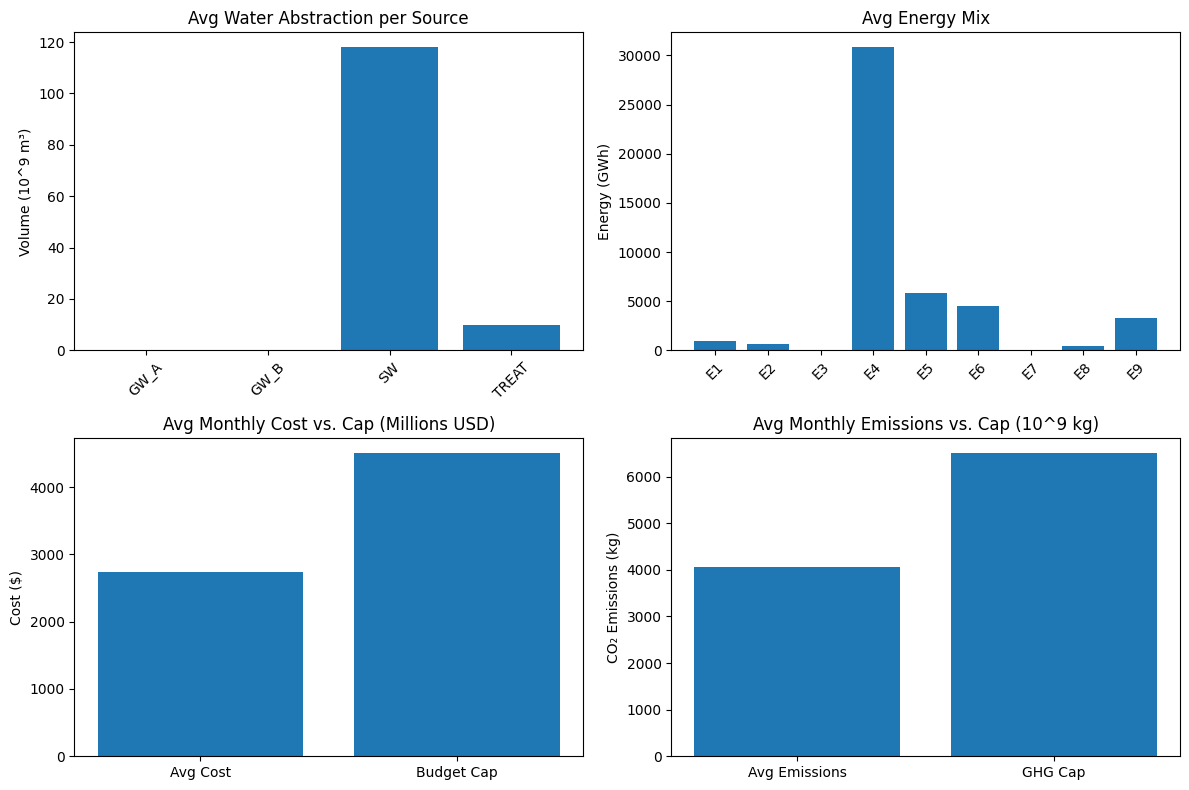

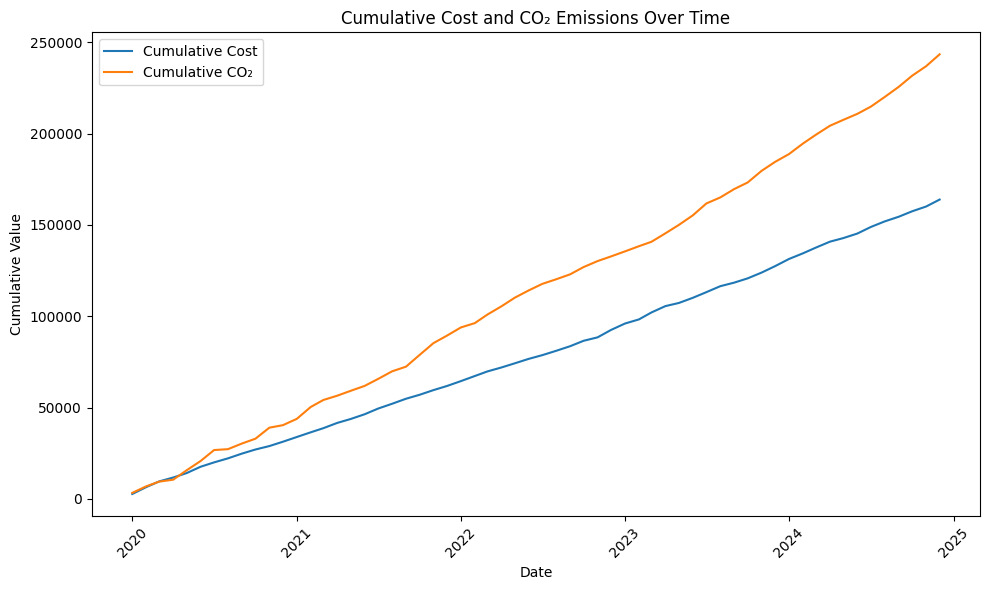

In [24]:
import matplotlib.pyplot as plt

# ——————————————
# KPI Dashboard (small multiples)
# ——————————————
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1) Avg. water abstraction per source
water_avg = df[['GW_A', 'GW_B', 'SW', 'TREAT']].mean()
axes[0, 0].bar(water_avg.index, water_avg.values)
axes[0, 0].set_title('Avg Water Abstraction per Source')
axes[0, 0].set_ylabel('Volume (10^9 m³)')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2) Avg. energy mix
energy_cols = ['E1','E2','E3','E4','E5','E6','E7','E8','E9']
energy_avg = df[energy_cols].mean()
axes[0, 1].bar(energy_avg.index, energy_avg.values)
axes[0, 1].set_title('Avg Energy Mix')
axes[0, 1].set_ylabel('Energy (GWh)')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3) Avg. monthly cost vs. cap
cost_vals = [df_metrics['Optimized Budget ($)'].mean(), df_metrics['Max Budget ($)'].mean()]
axes[1, 0].bar(['Avg Cost', 'Budget Cap'], cost_vals)
axes[1, 0].set_title('Avg Monthly Cost vs. Cap (Millions USD)')
axes[1, 0].set_ylabel('Cost ($)')

# 4) Avg. monthly emissions vs. cap
em_vals = [df_metrics['Optimized GHG (kgCO₂)'].mean(), df_metrics['Max allowable GHG'].mean()]
axes[1, 1].bar(['Avg Emissions', 'GHG Cap'], em_vals)
axes[1, 1].set_title('Avg Monthly Emissions vs. Cap (10^9 kg)')
axes[1, 1].set_ylabel('CO₂ Emissions (kg)')

plt.tight_layout()
plt.show()

# ——————————————
# Cumulative Curves
# ——————————————
fig, ax = plt.subplots(figsize=(10, 6))
cumulative_cost = df_metrics['Optimized Budget ($)'].cumsum()
cumulative_ghg  = df_metrics['Optimized GHG (kgCO₂)'].cumsum()

ax.plot(df_metrics.index, cumulative_cost)
ax.plot(df_metrics.index, cumulative_ghg)
ax.set_title('Cumulative Cost and CO₂ Emissions Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Value')
ax.legend(['Cumulative Cost', 'Cumulative CO₂'])
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
